In [13]:
import tifffile as tif
import spatialdata as sd
import matplotlib.pyplot as plt
import sopa

In [2]:
test_img = tif.imread(
    "/work/rwth1209/projects/merfish_segmentation/xenium/test_output/subsection_36000_18000.tif"
)
test_img.shape

(4, 1500, 1500)

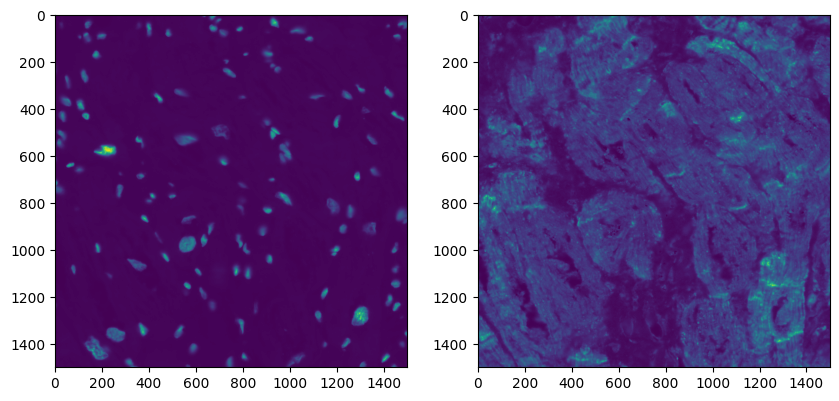

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_img[0, :, :])
ax[1].imshow(test_img[1, :, :]);

In [ ]:
sdata = sd.SpatialData()
sdata["crop"] = sd.models.Image2DModel.parse(test_img, c_coords=["0", "1", "2", "3"])

INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           


In [ ]:
sdata["crop"]

<xarray.DataArray 'image' (c: 4, y: 1500, x: 1500)> Size: 18MB
dask.array<array, shape=(4, 1500, 1500), dtype=uint16, chunksize=(4, 1500, 1500), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U1 16B '0' '1' '2' '3'
  * y        (y) float64 12kB 0.5 1.5 2.5 3.5 ... 1.498e+03 1.498e+03 1.5e+03
  * x        (x) float64 12kB 0.5 1.5 2.5 3.5 ... 1.498e+03 1.498e+03 1.5e+03
Attributes:
    transform:  {'global': Identity }

In [6]:
image_key = "crop"
patches = sopa.segmentation.Patches2D(
    sdata, image_key, patch_width=1200, patch_overlap=50
)
patches.write();

[INFO] (sopa.patches.patches) 4 patches were saved in sdata['sopa_patches']


In [7]:
sopa.utils.get_channel_names(sdata[image_key])

array(['0', '1', '2', '3'], dtype='<U1')

# Default Resolution

In [8]:
channels = ["1", "0"]

method = sopa.segmentation.methods.cellpose_patch(
    diameter=200, channels=channels, flow_threshold=2, cellprob_threshold=-6
)
segmentation = sopa.segmentation.StainingSegmentation(
    sdata, method, channels, min_area=2500
)
cellpose_temp_dir = ".sopa_cache/cellpose_default"
segmentation.write_patches_cells(cellpose_temp_dir)
cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir)
cells = sopa.segmentation.shapes.solve_conflicts(cells)

shapes_key = "cellpose_default"  # name of the key given to the cells in sdata.shapes

sopa.segmentation.StainingSegmentation.add_shapes(sdata, cells, image_key, shapes_key)

[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Reading patches: 100%|██████████| 4/4 [00:00<00:00, 299.61it/s]
[INFO] (sopa.segmentation.stainings) Found 83 total cells
Resolving conflicts: 100%|██████████| 40/40 [00:00<00:00, 14113.92it/s]
[INFO] (sopa.segmentation.stainings) Added 81 cell boundaries in sdata['cellpose_default']


In [9]:
sdata.images["crop"]

<xarray.DataArray 'image' (c: 4, y: 1500, x: 1500)> Size: 18MB
dask.array<array, shape=(4, 1500, 1500), dtype=uint16, chunksize=(4, 1500, 1500), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U1 16B '0' '1' '2' '3'
  * y        (y) float64 12kB 0.5 1.5 2.5 3.5 ... 1.498e+03 1.498e+03 1.5e+03
  * x        (x) float64 12kB 0.5 1.5 2.5 3.5 ... 1.498e+03 1.498e+03 1.5e+03
Attributes:
    transform:  {'global': Identity }

In [10]:
sdata.images["crop"]

<xarray.DataArray 'image' (c: 4, y: 1500, x: 1500)> Size: 18MB
dask.array<array, shape=(4, 1500, 1500), dtype=uint16, chunksize=(4, 1500, 1500), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U1 16B '0' '1' '2' '3'
  * y        (y) float64 12kB 0.5 1.5 2.5 3.5 ... 1.498e+03 1.498e+03 1.5e+03
  * x        (x) float64 12kB 0.5 1.5 2.5 3.5 ... 1.498e+03 1.498e+03 1.5e+03
Attributes:
    transform:  {'global': Identity }

In [11]:
sdata.write("resolution_test.zarr")

INFO     The Zarr backing store has been changed from None the new file path: resolution_test.zarr                 


In [15]:
sdata

SpatialData object, with associated Zarr store: /rwthfs/rz/cluster/work/rwth1209/projects/merfish_segmentation/xenium/resolution_test.zarr
├── Images
│     └── 'crop': DataArray[cyx] (4, 1500, 1500)
└── Shapes
      ├── 'cellpose_default': GeoDataFrame shape: (81, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (4, 3) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        crop (Images), cellpose_default (Shapes), sopa_patches (Shapes)

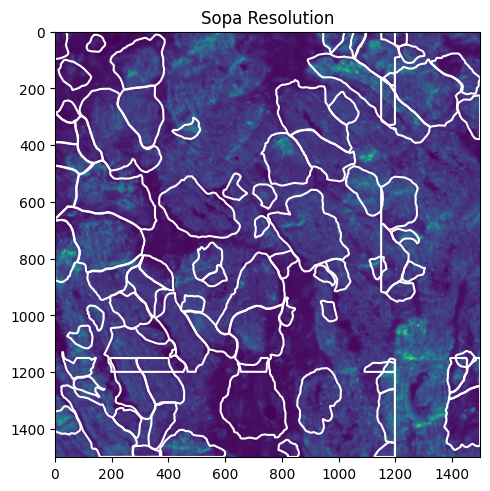

In [14]:
sdata.pl.render_shapes(
    "cellpose_default",
    fill_alpha=0,
    outline_color="white",
    outline_alpha=1,
    outline=True,
).pl.render_images(channel="1").pl.show(title="Sopa Resolution")

# My resolution

In [16]:
sdata = sd.read_zarr(
    "/work/rwth1209/projects/merfish_segmentation/xenium/resolution_test.zarr"
)
sdata

SpatialData object, with associated Zarr store: /rwthfs/rz/cluster/work/rwth1209/projects/merfish_segmentation/xenium/resolution_test.zarr
├── Images
│     └── 'crop': DataArray[cyx] (4, 1500, 1500)
└── Shapes
      ├── 'cellpose_boundaries': GeoDataFrame shape: (52, 1) (2D shapes)
      ├── 'cellpose_default': GeoDataFrame shape: (81, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (4, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        crop (Images), cellpose_boundaries (Shapes), cellpose_default (Shapes), sopa_patches (Shapes)

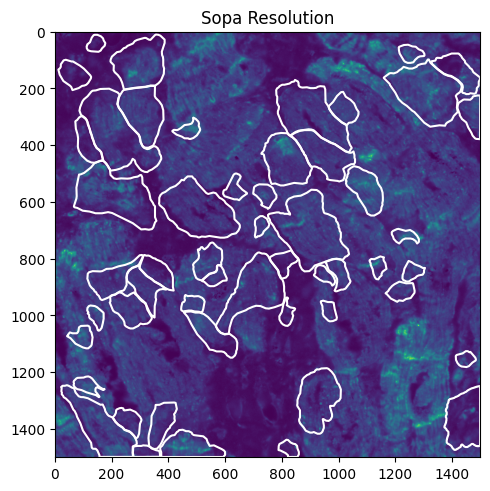

In [22]:
sdata.pl.render_shapes(
    "vpt_stype",
    fill_alpha=0,
    outline_color="white",
    outline_alpha=1,
    outline=True,
).pl.render_images(channel="1").pl.show(title="Sopa Resolution")